### 🧩 Needed Imports


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import os, json
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report, roc_curve
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

### 📦 Function: `aggregate_taskset_features`

**Purpose**:
Aggregates task-level features into **set-level representations** for classification experiments.
This prepares the dataset so that each row corresponds to a *task set* rather than individual tasks.

---

**How It Works**:
1. **Compute Derived Per-Task Features**
   - `criticality = C / D`
   - `interference = C / T`
   - `harmonicity = |unique(T)| / n_tasks`

2. **Aggregate Across Each Task Set**
   - Apply mean, min, max, std to `C`, `D`, `U`
   - Aggregate helper features like `inv_T`, `hp_util`
   - Preserve `U_total` and `n_tasks`

3. **Optional Features**
   - If `include_ml_engineered_features=True`: add engineered summaries
   - If `include_schedulable=True`: include a set-level schedulability label (`1` only if all tasks are schedulable)

4. **Return Cleaned DataFrame**
   - Each row = one task set with aggregated stats
   - Ready for use in **classification models**

---

**Why It Matters**:
Machine learning models for schedulability classification need **set-level inputs**.
This function bridges raw per-task data → aggregated features, enabling effective model training.


In [3]:
def aggregate_taskset_features(df: pd.DataFrame, include_ml_engineered_features: bool = False,
                               include_schedulable: bool = False) -> pd.DataFrame:
    df = df.copy()

    # Derived per-task features (always computed, but may or may not be aggregated)
    df['criticality'] = df['C'] / df['D']
    df['interference'] = df['C'] / df['T']
    df['harmonicity'] = df.groupby('taskset_id')['T'].transform(lambda x: len(set(x)) / len(x))

    # Base aggregation functions
    agg_funcs = {
        'C': ['mean', 'max', 'min', 'std'],
        'D': ['mean', 'max', 'min', 'std'],
        'U': ['mean', 'max', 'min', 'std'],
        'inv_T': ['mean', 'std'],
        'hp_util': ['mean', 'std'],
        'U_total': 'first',
        'n_tasks': 'first'
    }

    # Optional ML-engineered features
    if include_ml_engineered_features:
        agg_funcs['criticality'] = 'mean'
        agg_funcs['interference'] = 'max'
        agg_funcs['harmonicity'] = 'mean'

    if include_schedulable:
        agg_funcs['schedulable'] = lambda x: 1 if all(x == 1) else 0

    # Group and aggregate
    df_grouped = df.groupby("taskset_id").agg(agg_funcs)

    # Clean column names
    df_grouped.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_grouped.columns.values]
    if include_schedulable:
        df_grouped.rename(columns={'schedulable_<lambda>': 'schedulable'}, inplace=True)
    df_grouped.reset_index(drop=True, inplace=True)

    return df_grouped

In [4]:
def prepare_dataset_classification(csv_path: str, include_ml_engineered_features: bool = False):
    df = pd.read_csv(csv_path)
    df_grouped = aggregate_taskset_features(
        df,
        include_ml_engineered_features=include_ml_engineered_features,
        include_schedulable=True
    )
    X = df_grouped.drop(columns=["schedulable"])
    y = df_grouped["schedulable"]
    return train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [5]:
def train_classification_models(X_train, y_train, model_type, variant="default"):
    if model_type == "random_forest":
        clf = RandomForestClassifier(
            n_estimators=100, max_depth=10, class_weight='balanced',
            random_state=42, n_jobs=-1)
    elif model_type == "logistic_regression":
        clf = LogisticRegression(
            max_iter=1000, class_weight='balanced', random_state=42)
    elif model_type == "xgboost":
        clf = XGBClassifier(
            n_estimators=100, max_depth=6,
            scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
            eval_metric='logloss')
    else:
        raise ValueError("Unsupported model type")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    pipeline.fit(X_train, y_train)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    cv_results = {
        "model": model_type,
        "variant": variant,
        "cv_mean_accuracy": mean_cv,
        "cv_std": std_cv,
        "cv_scores": cv_scores.tolist()
    }

    # Save CV results with variant tag
    filename = f"../models/classification_models/{model_type}_{variant}_cv.json"
    with open(filename, "w") as f:
        json.dump(cv_results, f, indent=2)

    return pipeline

In [6]:
def evaluate_models(X_test, y_test, model_paths, variant="default"):
    results = []
    plt.figure(figsize=(8, 6))

    for model_name, model_path in model_paths.items():
        pipeline = joblib.load(model_path)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        conf = confusion_matrix(y_test, y_pred)

        # 🔍 Try to load and display CV results
        cv_info = "N/A"
        cv_path = f"../models/classification_models/{model_name}_{variant}_cv.json"
        if os.path.exists(cv_path):
            with open(cv_path, "r") as f:
                cv_data = json.load(f)
                cv_info = f"{cv_data['cv_mean_accuracy']:.4f} ± {cv_data['cv_std']:.4f}"

        results.append({
            "Model": model_name,
            "Accuracy": acc,
            "F1 Score": f1,
            "ROC-AUC": roc_auc,
            "FP": conf[0][1],
            "FN": conf[1][0],
            "CV Accuracy": cv_info
        })

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")

        print(f"\n=== {model_name.upper()} ===")
        print(f"CV Accuracy: {cv_info}")
        print("Confusion Matrix:\n", conf)
        print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Feature Importance for XGBoost
    if "xgboost" in model_paths:
        xgb_model = joblib.load(model_paths["xgboost"])
        importances = xgb_model.named_steps['clf'].feature_importances_
        feature_names = X_test.columns
        sorted_idx = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx])
        plt.title("XGBoost Feature Importances")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)


🔍 STEP 1: Training Models WITHOUT ML-Engineered Features
📦 random_forest (basic) already trained.
📦 logistic_regression (basic) already trained.
📦 xgboost (basic) already trained.

=== RANDOM_FOREST ===
CV Accuracy: 0.8440 ± 0.0013
Confusion Matrix:
 [[132173  26498]
 [  4852  36477]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9646    0.8330    0.8940    158671
           1     0.5792    0.8826    0.6994     41329

    accuracy                         0.8433    200000
   macro avg     0.7719    0.8578    0.7967    200000
weighted avg     0.8850    0.8433    0.8538    200000


=== LOGISTIC_REGRESSION ===
CV Accuracy: 0.8476 ± 0.0012
Confusion Matrix:
 [[132643  26028]
 [  4284  37045]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9687    0.8360    0.8975    158671
           1     0.5873    0.8963    0.7097     41329

    accuracy                         0.8484    200000
   macro 

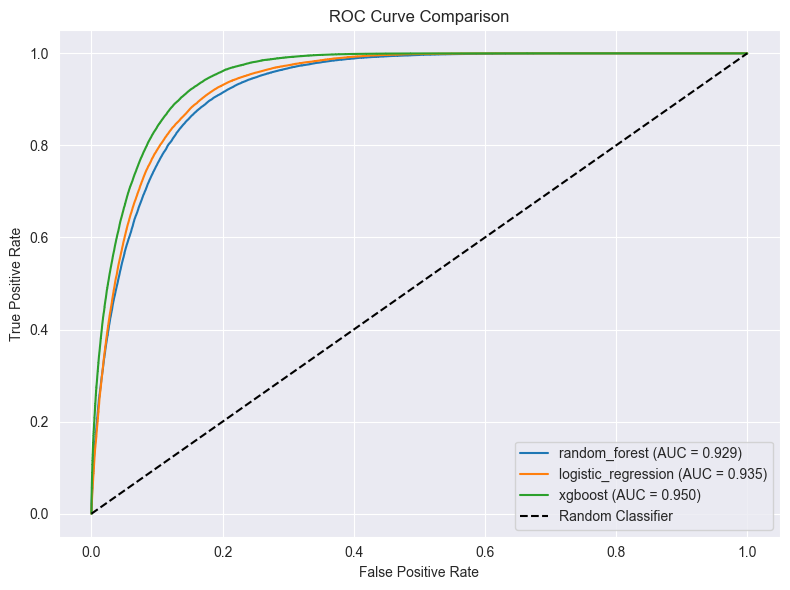

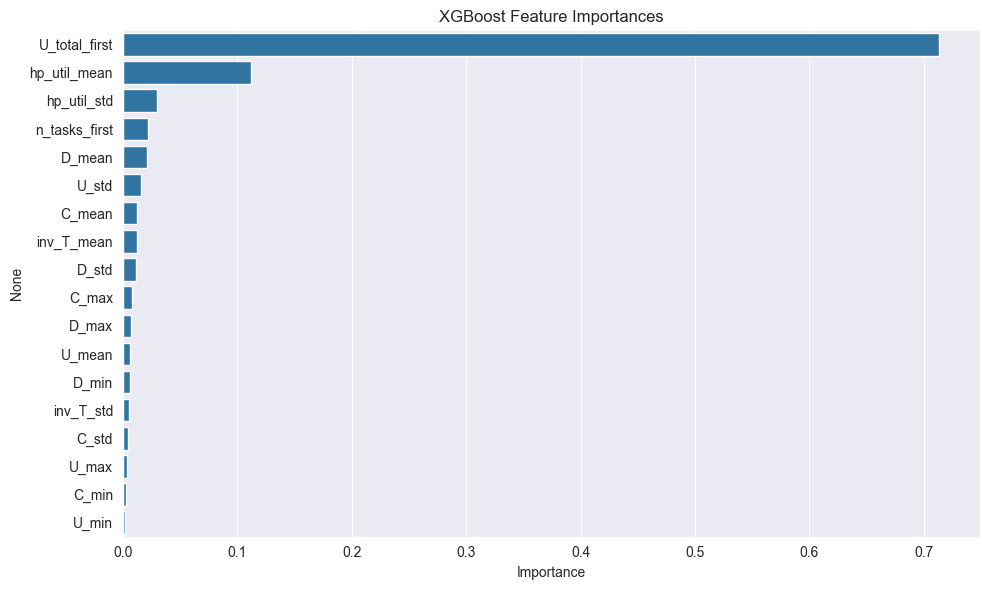


🧪 Evaluation (No Engineered Features)
--------------------------------------------------
                 Model  Accuracy  F1 Score   ROC-AUC     FP    FN  \
0        random_forest  0.843250  0.699436  0.928634  26498  4852   
1  logistic_regression  0.848440  0.709661  0.934953  26028  4284   
2              xgboost  0.866395  0.739132  0.950176  23247  3474   

       CV Accuracy  
0  0.8440 ± 0.0013  
1  0.8476 ± 0.0012  
2  0.8656 ± 0.0011  



🔬 STEP 2: Training Models WITH ML-Engineered Features
📦 random_forest (engineered) already trained.
📦 logistic_regression (engineered) already trained.
📦 xgboost (engineered) already trained.

=== RANDOM_FOREST ===
CV Accuracy: 0.8924 ± 0.0009
Confusion Matrix:
 [[140207  18464]
 [  2772  38557]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9806    0.8836    0.9296    158671
           1     0.6762    0.9329    0.7841     41329

    accuracy                         0.8938    200000
   mac

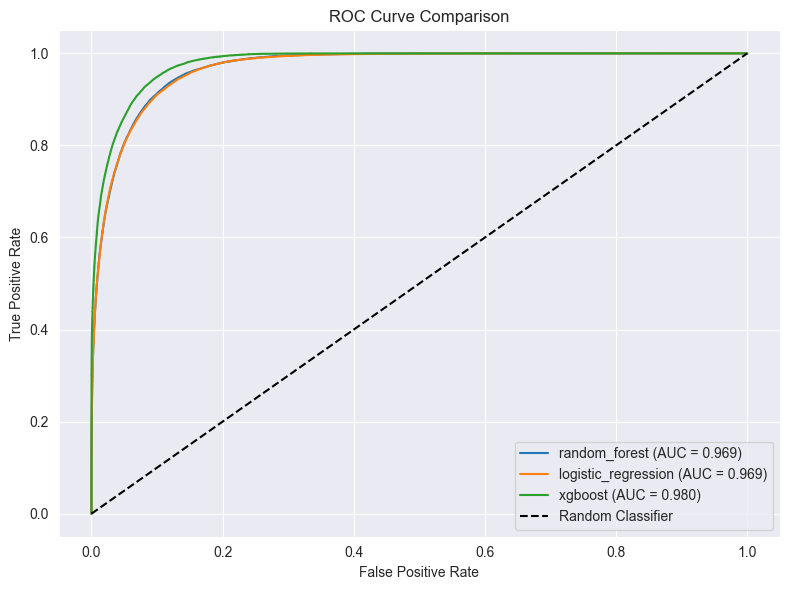

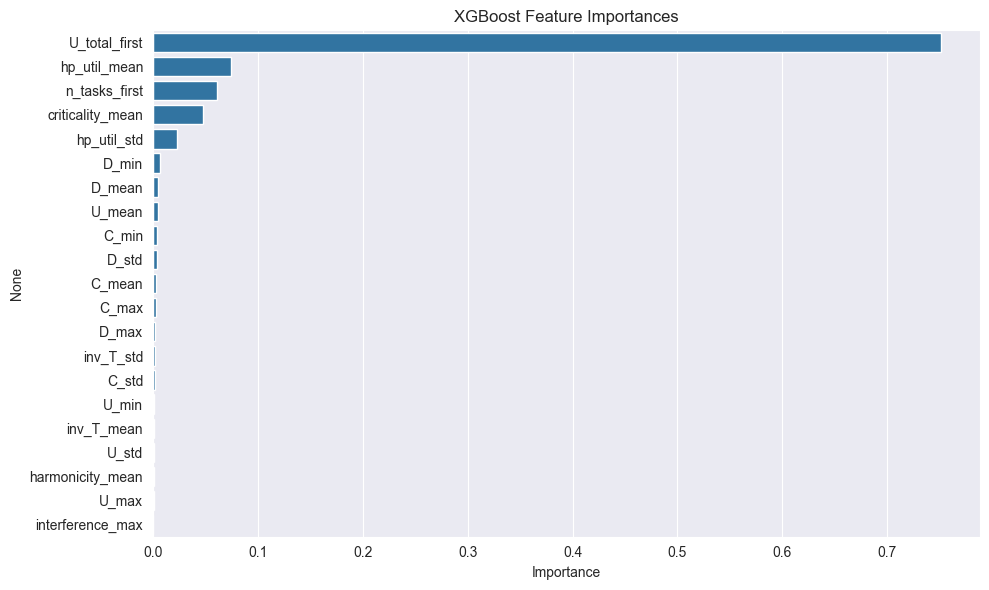


🧪 Evaluation (With Engineered Features)
--------------------------------------------------
                 Model  Accuracy  F1 Score   ROC-AUC     FP    FN  \
0        random_forest  0.893820  0.784077  0.969459  18464  2772   
1  logistic_regression  0.894935  0.784219  0.968926  17868  3145   
2              xgboost  0.913855  0.818804  0.979664  14828  2401   

       CV Accuracy  
0  0.8924 ± 0.0009  
1  0.8941 ± 0.0012  
2  0.9128 ± 0.0009  


In [8]:
# --- Step 1: Basic Features (No ML-Engineered Features)
print("=" * 50)
print("🔍 STEP 1: Training Models WITHOUT ML-Engineered Features")
print("=" * 50)

X_train_basic, X_test_basic, y_train_basic, y_test_basic = prepare_dataset_classification(
    "../data/main_dataset.csv", include_ml_engineered_features=False)

for model_type in ["random_forest", "logistic_regression", "xgboost"]:
    model_path = f"../models/classification_models/{model_type}_basic.pkl"
    if not os.path.exists(model_path):
        print(f"🚀 Training {model_type} (basic)...")
        pipeline = train_classification_models(X_train_basic, y_train_basic, model_type, variant="basic")
        joblib.dump(pipeline, model_path)
    else:
        print(f"📦 {model_type} (basic) already trained.")

results_basic = evaluate_models(X_test_basic, y_test_basic, {
    "random_forest": "../models/classification_models/random_forest_basic.pkl",
    "logistic_regression": "../models/classification_models/logistic_regression_basic.pkl",
    "xgboost": "../models/classification_models/xgboost_basic.pkl"
}, variant="basic")

print("\n🧪 Evaluation (No Engineered Features)")
print("-" * 50)
print(results_basic)
print("\n\n")

# --- Step 2: With Engineered Features
print("=" * 50)
print("🔬 STEP 2: Training Models WITH ML-Engineered Features")
print("=" * 50)

X_train_eng, X_test_eng, y_train_eng, y_test_eng = prepare_dataset_classification(
    "../data/main_dataset.csv", include_ml_engineered_features=True)

for model_type in ["random_forest", "logistic_regression", "xgboost"]:
    model_path = f"../models/classification_models/{model_type}_engineered.pkl"
    if not os.path.exists(model_path):
        print(f"🚀 Training {model_type} (engineered)...")
        pipeline = train_classification_models(X_train_eng, y_train_eng, model_type, variant="engineered")
        joblib.dump(pipeline, model_path)
    else:
        print(f"📦 {model_type} (engineered) already trained.")

results_eng = evaluate_models(X_test_eng, y_test_eng, {
    "random_forest": "../models/classification_models/random_forest_engineered.pkl",
    "logistic_regression": "../models/classification_models/logistic_regression_engineered.pkl",
    "xgboost": "../models/classification_models/xgboost_engineered.pkl"
}, variant="engineered")

print("\n🧪 Evaluation (With Engineered Features)")
print("-" * 50)
print(results_eng)
